In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import time
from tqdm import tqdm
import re

# Functions

In [2]:
def getDraftURL(year):
    return f"https://www.basketball-reference.com/draft/NBA_{year}.html"

def getSoupFromURL(url):
    """
    Get soup from given url
    """
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    return soup

def getRows(table):
    return table.find('tbody').find_all('tr')

def gatherInfo(table):
    rows = getRows(table)
    data = {'Pk' : [], 'Name' : [], 'Ref' : []}
    for r in rows:
        # ensure that we aren't getting a header row
        num_data_cells = len(r.find_all('td'))
        if num_data_cells < 10:
            continue
        # find relevant information
        pk = int(r.find(attrs = {'data-stat' : 'ranker'}).text)
        name = r.find(attrs = {'data-stat' : 'player'}).text
        reference = r.find(attrs = {'data-stat' : 'player'}).find('a')['href']
        # store data in dictionary of lists
        data['Pk'].append(pk)
        data['Name'].append(name)
        data['Ref'].append(reference)
    return pd.DataFrame(data)

In [3]:
def scrapeStats(player_page, table_id):
    table = player_page.find('table', attrs = {'id' : table_id})
    headers = table.find('thead').find_all('th')
    headers = [h.text for h in headers]
    body = table.find('tbody')
    data_dict = {h : [] for h in headers}
    year_rows = body.find_all('tr', attrs = {'class' : 'full_table'})
    for row in year_rows:
        season = row.find('th').text
        data_dict['Season'].append(season)
        for i, cell in enumerate(row.find_all('td')):
            data_dict[headers[i + 1]].append(cell.text)
    # del data_dict["\xa0"]
    if "\xa0" in data_dict:
        del data_dict["\xa0"]
    return pd.DataFrame(data_dict)

def cleanData(df):
    df['Season'] = df['Season'].str[:4].astype(int)
    dont_convert = ['Tm', 'Lg', 'Pos', 'Awards', 'Season']
    for col in df.columns:
        if col in dont_convert:
            continue
        df[col] = np.where(df[col] == '', '0.0', df[col])
        has_decimal = any(df[col].str.contains('[.]'))
        if has_decimal:
            df[col] = df[col].astype(float)
        else:
            df[col] = df[col].astype(int)
    # prevent errors for if player has an appearance but 0 mins in a season (so less than 1 real minute)
    if 'MP' in df:
        df['MP'] = np.where(df['MP'] == 0, 1, df['MP'])
    return df

def scrapePlayer(href):
    player_url = "https://www.basketball-reference.com" + href
    player_page = getSoupFromURL(player_url)
    return player_page

def collectAwards(awards_list):
    aws = {'NBA' : 0, 'AS' : 0, 'DEF' : 0}
    for aw in awards_list:
        if aw == '':
            continue
        if "," in aw:
            aw = aw.split(',')
        else:
            aw = [aw]
        for a in aw:
            for aw_type in aws.keys():
                if aw_type in a:
                    aws[aw_type] += 1
    return aws

def collectFromPerGame(pergame_df):
    years = len(pergame_df)
    total_games = pergame_df['G'].sum()
    total_starts = pergame_df['GS'].sum()
    ppg = np.average(pergame_df['PTS'], weights = pergame_df['G'])
    apg = np.average(pergame_df['AST'], weights = pergame_df['G'])
    awards = collectAwards(pergame_df['Awards'])
    pct_start = total_starts / total_games
    return {'G' : total_games, 'PPG' : ppg, 'APG' : apg, 'Start%' : pct_start, 'All-NBA' : awards['NBA'],
            'All Star' : awards['AS'], 'All-Defense' : awards['DEF']}
    # return total_games, ppg, apg, cpg, pct_start, awards

def collectFromTotals(total_df):
    tpm = total_df['3P'].sum()
    tpa = total_df['3PA'].sum()
    pts = total_df['PTS'].sum()
    ast = total_df['AST'].sum()
    reb = total_df['TRB'].sum()
    mins = total_df['MP'].sum()
    if tpa > 0:
        pct = tpm / tpa
    else:
        pct = 0
    tpm_36 = 36 * tpm / mins
    pts_36 = 36 * pts / mins
    ast_36 = 36 * ast / mins
    reb_36 = 36 * reb / mins
    return {'3P%' : pct, '3PM_36' : tpm_36, 'PTS_36' : pts_36, 'AST_36' : ast_36, 'REB_36' : reb_36}
    # return pct, tpm_36, pts_36, ast_36, create_36

def collectFromAdvanced(adv_df):
    obpm = np.average(adv_df['OBPM'], weights = adv_df['MP'])
    dbpm = np.average(adv_df['DBPM'], weights = adv_df['MP'])
    tsp = np.average(adv_df['TS%'], weights = adv_df['MP'])
    usg = np.average(adv_df['USG%'], weights = adv_df['MP'])
    tovp = np.average(adv_df['TOV%'], weights = adv_df['MP'])
    return {'OBPM' : obpm, 'DBPM' : dbpm, 'TS%' : tsp, 'USG%' : usg, 'TOV%' : tovp}
    # return dbpm, tsp, usg
    

def mergeDicts(dict_list):
    super_dict = {}
    for d in dict_list:
        for k, v in d.items():
            super_dict[k] = v
    return super_dict


def collectOutcomes(year):
    time.sleep(2)
    draft_soup = getSoupFromURL(getDraftURL(year))
    draft_table = draft_soup.find('table')
    draft_df = gatherInfo(draft_table)
    all_data = {}
    for _, row in tqdm(draft_df.iterrows(), total = len(draft_df)):
        time.sleep(2)
        s = scrapePlayer(row['Ref'])
        if s.find('table', attrs = {'id' : 'per_game'}) is None:
            all_data[row['Name']] = {'Pk' : row['Pk']}
            continue
        pergame = cleanData(scrapeStats(s, 'per_game'))
        totals = cleanData(scrapeStats(s, 'totals'))
        adv = cleanData(scrapeStats(s, 'advanced'))
        pergame_stats = collectFromPerGame(pergame)
        total_stats = collectFromTotals(totals)
        adv_stats = collectFromAdvanced(adv)
        all_stats = mergeDicts([pergame_stats, total_stats, adv_stats])
        all_data[row['Name']] = all_stats
        all_data[row['Name']]['Pk'] = row['Pk']
    stats_df = pd.DataFrame(all_data).T
    stats_df['Year'] = year
    return stats_df

In [4]:
# Test to see if it works
test = collectOutcomes(2007)

100%|███████████████████████████████████████████| 60/60 [02:23<00:00,  2.39s/it]


In [5]:
test.head()

,G,PPG,APG,Start%,All-NBA,All Star,All-Defense,3P%,3PM_36,PTS_36,AST_36,REB_36,OBPM,DBPM,TS%,USG%,TOV%,Pk,Year
Greg Oden,105.0,8.025714,0.470476,0.628571,0.0,0.0,0.0,0.000000,0.000000,14.911243,0.905325,11.644970,-1.207002,0.858876,0.607536,19.301578,16.669231,1.0,2007
Kevin Durant,1061.0,27.260038,4.375306,0.997172,10.0,14.0,0.0,0.387005,1.876116,26.718259,4.290773,6.885559,5.891548,0.703834,0.618665,30.174802,12.576460,2.0,2007
Al Horford,1078.0,13.137848,3.246660,0.961039,1.0,5.0,1.0,0.378901,0.905806,14.886949,3.678916,9.009720,1.677501,1.285011,0.575942,18.235232,10.986783,3.0,2007
Mike Conley,1101.0,14.428065,5.720163,0.966394,0.0,1.0,1.0,0.387325,1.862978,16.416521,6.515772,3.380844,2.046210,0.416446,0.555327,21.096208,13.058867,4.0,2007
Jeff Green,1185.0,12.009367,1.488861,0.554430,0.0,0.0,0.0,0.337072,1.283954,15.601351,1.932504,5.284806,-0.754773,-0.710998,0.551995,19.639418,10.768902,5.0,2007


# Gather Data

In [7]:
df_list = []
for yr in range(2004, 2021):
    print(f"Scraping {yr}")
    stats_df = collectOutcomes(yr)
    df_list.append(stats_df)

Scraping 2004


100%|███████████████████████████████████████████| 59/59 [02:19<00:00,  2.37s/it]


Scraping 2005


100%|███████████████████████████████████████████| 60/60 [02:28<00:00,  2.47s/it]


Scraping 2006


100%|███████████████████████████████████████████| 60/60 [02:24<00:00,  2.41s/it]


Scraping 2007


100%|███████████████████████████████████████████| 60/60 [02:19<00:00,  2.32s/it]


Scraping 2008


100%|███████████████████████████████████████████| 60/60 [02:22<00:00,  2.38s/it]


Scraping 2009


100%|███████████████████████████████████████████| 60/60 [02:21<00:00,  2.36s/it]


Scraping 2010


100%|███████████████████████████████████████████| 60/60 [02:22<00:00,  2.37s/it]


Scraping 2011


100%|███████████████████████████████████████████| 60/60 [02:22<00:00,  2.37s/it]


Scraping 2012


100%|███████████████████████████████████████████| 60/60 [02:20<00:00,  2.34s/it]


Scraping 2013


100%|███████████████████████████████████████████| 60/60 [02:22<00:00,  2.38s/it]


Scraping 2014


100%|███████████████████████████████████████████| 60/60 [02:20<00:00,  2.35s/it]


Scraping 2015


100%|███████████████████████████████████████████| 60/60 [02:25<00:00,  2.42s/it]


Scraping 2016


100%|███████████████████████████████████████████| 60/60 [02:22<00:00,  2.38s/it]


Scraping 2017


100%|███████████████████████████████████████████| 60/60 [02:22<00:00,  2.37s/it]


Scraping 2018


100%|███████████████████████████████████████████| 60/60 [02:26<00:00,  2.45s/it]


Scraping 2019


100%|███████████████████████████████████████████| 60/60 [02:24<00:00,  2.40s/it]


Scraping 2020


100%|███████████████████████████████████████████| 60/60 [02:23<00:00,  2.39s/it]


In [8]:
all_outcomes = pd.concat(df_list)
all_outcomes = all_outcomes.reset_index(names = 'Player')

In [9]:
cols = ['Player', 'Year', 'Pk'] + all_outcomes.columns.tolist()[1:-2]
all_outcomes = all_outcomes[cols]

In [17]:
all_outcomes.to_csv('data/outcomes.csv', index = False)

# Scratch Work

In [20]:
s = scrapePlayer("/players/d/duranke01.html")
t = scrapeStats(s, 'advanced')
x = cleanData(t)
collectFromAdvanced(x)

{'DBPM': 0.7038335215026172,
 'TS%': 0.6186646310171404,
 'USG%': 30.174802422251872}

In [5]:
s = scrapePlayer('/players/h/horfoal01.html')
t = scrapeStats(s, 'advanced')
x = cleanData(t)
x
collectFromAdvanced(x)

{'DBPM': 1.2850112379228815,
 'TS%': 0.575942029831577,
 'USG%': 18.22947254735982}

In [6]:
for table in s.find_all('table'):
    print(table['id'])

last5
per_game
playoffs_per_game
stathead_insights
totals
playoffs_totals
advanced
playoffs_advanced


In [7]:
s = getSoupFromURL(getDraftURL(2007))
table = s.find('table')
test = gatherInfo(table)
test

,Pk,Name,Ref
0,1,Greg Oden,/players/o/odengr01.html
1,2,Kevin Durant,/players/d/duranke01.html
2,3,Al Horford,/players/h/horfoal01.html
3,4,Mike Conley,/players/c/conlemi01.html
4,5,Jeff Green,/players/g/greenje02.html
5,6,Yi Jianlian,/players/j/jianlyi01.html
6,7,Corey Brewer,/players/b/breweco01.html
7,8,Brandan Wright,/players/w/wrighbr03.html
8,9,Joakim Noah,/players/n/noahjo01.html
9,10,Spencer Hawes,/players/h/hawessp01.html


In [17]:
all_data = {}
for _, row in tqdm(test.iterrows(), total = len(test)):
    time.sleep(2)
    # print(row['Pk'], row['Name'])
    s = scrapePlayer(row['Ref'])
    if s.find('table', attrs = {'id' : 'per_game'}) is None:
        # print("\tNo Stats")
        all_data[row['Name']] = {}
        continue
    pergame = cleanData(scrapeStats(s, 'per_game'))
    totals = cleanData(scrapeStats(s, 'totals'))
    adv = cleanData(scrapeStats(s, 'advanced'))
    pergame_stats = collectFromPerGame(pergame)
    total_stats = collectFromTotals(totals)
    adv_stats = collectFromAdvanced(adv)
    all_stats = mergeDicts([pergame_stats, total_stats, adv_stats])
    all_data[row['Name']] = all_stats
    # print(f"\t{pergame_stats}")
    # print(f"\t{total_stats}")
    # print(f"\t{adv_stats}")

100%|███████████████████████████████████████████| 60/60 [02:20<00:00,  2.35s/it]


In [33]:
stats_df = pd.DataFrame(all_data).T
stats_df.sort_values('All-NBA', ascending = False)

,G,PPG,APG,CPG,Start%,All-NBA,All Star,All-Defense,3P%,3PM_36,PTS_36,AST_36,CREATE_36,DBPM,TS%,USG%
Kevin Durant,1061.0,27.260038,4.375306,31.635344,0.997172,10.0,14.0,0.0,0.387005,1.876116,26.718259,4.290773,31.009032,0.703834,0.618665,30.174802
Marc Gasol,891.0,14.034680,3.362290,17.396970,0.971942,2.0,3.0,1.0,0.360067,0.540270,15.686619,3.755563,19.442181,1.795094,0.560317,20.446520
Al Horford,1078.0,13.137848,3.246660,16.384508,0.961039,1.0,5.0,1.0,0.378901,0.905806,14.886949,3.678916,18.565866,1.285011,0.575942,18.229473
Joakim Noah,672.0,8.747321,2.837946,11.585268,0.761905,1.0,2.0,3.0,0.000000,0.000000,11.354500,3.681862,15.036362,2.090438,0.538296,15.955948
Greg Oden,105.0,8.025714,0.470476,8.496190,0.628571,0.0,0.0,0.0,0.000000,0.000000,14.911243,0.905325,15.816568,0.858876,0.607536,19.301578
Kyrylo Fesenko,135.0,2.253333,0.277778,2.531111,0.051852,0.0,0.0,0.0,0.000000,0.000000,9.918699,1.300813,11.219512,-0.171454,0.487444,15.392412
Alando Tucker,51.0,4.141176,0.323529,4.464706,0.019608,0.0,0.0,0.0,0.294118,0.845070,17.830986,1.352113,19.183099,-3.702817,0.506408,23.514085
Carl Landry,513.0,10.805263,0.691423,11.496686,0.181287,0.0,0.0,0.0,0.300000,0.028115,17.309615,1.108990,18.418605,-0.770574,0.595060,20.543362
Gabe Pruitt,62.0,2.024194,0.824194,2.848387,0.000000,0.0,0.0,0.0,0.283333,1.327549,9.761388,4.060738,13.822126,1.276356,0.417672,17.633406
Marcus Williams,13.0,1.069231,0.253846,1.323077,0.000000,0.0,0.0,0.0,0.000000,0.000000,12.923077,2.769231,15.692308,-1.969231,0.307692,26.207692



<!DOCTYPE html>

<html class="no-js" data-root="" data-version="klecko-" lang="en">
<head id="suppress_all_ads">
<meta charset="utf-8"/>
<meta content="ie=edge" http-equiv="x-ua-compatible"/>
<meta content="width=device-width, initial-scale=1.0, maximum-scale=2.0" name="viewport">
<title>Rate Limited Request (429 error) | Sports-Reference.com</title>
<link href="https://www.sports-reference.com/429.html" rel="canonical"/>
<!-- CSS start -->
<style>body,html{color:#000;font:14px/1.25 Helvetica Neue,helvetica,arial,sans-serif;margin:0;padding:0}html:not(.backstop){scroll-behavior:smooth}html:not(.backstop) div,html:not(.backstop) span{scroll-snap-margin:2.5em 0 0 0;scroll-margin:2.5em 0 0 0}body{-webkit-text-size-adjust:none;-moz-text-size-adjust:none;-ms-text-size-adjust:none;background:#c9cbcd;position:relative;z-index:0}a img{border:0}li,ol,ul{list-style-type:none;margin:0;padding:0}table td,table th{border:0}iframe{max-width:100%}code{background:#eee}a,button,input,label,select,summ
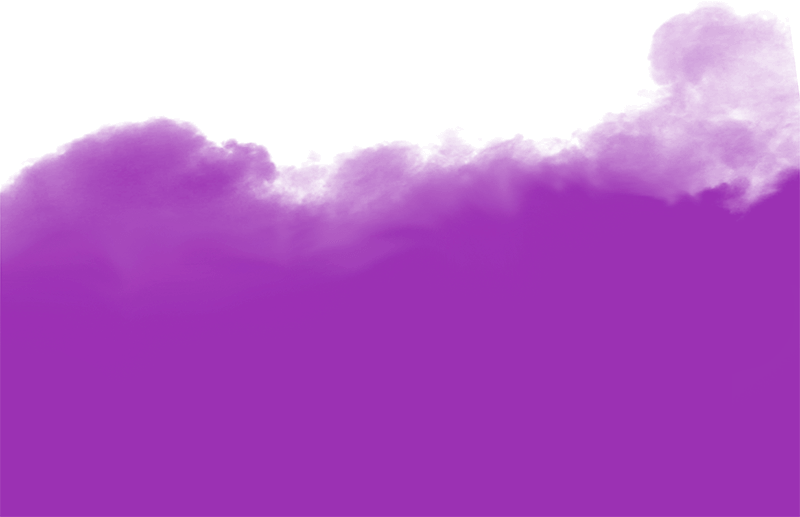

In [5]:
x = scrapePlayer("/players/o/odengr01.html")
x

In [59]:
test_ref = "/players/o/odengr01.html"
root = "https://www.basketball-reference.com"
player_url = root + test_ref

In [60]:
s = getSoupFromURL(player_url)

In [62]:
s.find('table')

<table class="stats_table sortable row_summable" data-cols-to-freeze="1,3" id="per_game"> <caption>Per Game Table</caption> <colgroup><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/></colgroup> <thead> <tr> <th aria-label="Season" class="poptip sort_default_asc center" data-stat="season" data-tip="If listed as single number, the year the season ended.&lt;br&gt;★ - Indicates All-Star for league.&lt;br&gt;Only on regular season tables." scope="col">Season</th> <th aria-label="Age" class="poptip sort_default_asc center" data-stat="age" data-tip="Player's age on February 1 of the season" scope="col">Age</th> <th aria-label="Tm" class="poptip sort_default_asc center" data-stat="team_id" data-tip="Team" scope="col">Tm</th> <th aria-label="Lg" class="poptip sort_default_asc center" data-stat="lg_id" data-tip="League" scope="col">Lg</th> <th aria-label="Pos"